In [0]:
spark

Out[13]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.2.1 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

## Import data from the cloud

In [0]:
ad_info = spark.read.csv("/mnt/course-datasets/project-data/ad_info.txt")
category = spark.read.csv("/mnt/course-datasets/project-data/category.txt")
combined_stream = spark.read.csv("/mnt/course-datasets/project-data/combined_stream.txt")
location = spark.read.csv("/mnt/course-datasets/project-data/location.txt")
search_click = spark.read.csv("/mnt/course-datasets/project-data/search_click.txt")
search_info = spark.read.csv("/mnt/course-datasets/project-data/search_info.txt")
user_info = spark.read.csv("/mnt/course-datasets/project-data/user_info.txt")

## Clean the data

In [0]:
from pyspark.sql.functions import col, split, monotonically_increasing_id

In [0]:
ad_info_df = ad_info.withColumn("newcol", split(col("_c0"), "\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn("AdID", col("newcol").getItem(0)) \
    .withColumn("LocationID", col("newcol").getItem(1)) \
    .withColumn("CategoryID", col("newcol").getItem(2)) \
    .withColumn("Params", col("newcol").getItem(3)) \
    .withColumn("Price", col("newcol").getItem(4)) \
    .withColumn("Title", col("newcol").getItem(5)) \
    .filter(col("idx") >= 1) \
    .select("AdID", "LocationID", "CategoryID", "Params", "Price", "Title").cache()

category_df = category.withColumn("newcol", split(col("_c0"), "\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn("CategoryID", col("newcol").getItem(0)) \
    .withColumn("Level", col("newcol").getItem(1)) \
    .withColumn("ParentCategoryID", col("newcol").getItem(2)) \
    .withColumn("SubcategoryID", col("newcol").getItem(3)) \
    .filter(col("idx") >= 1) \
    .select("CategoryID", "Level", "ParentCategoryID", "SubcategoryID").cache()

combined_stream_df = combined_stream.withColumn("newcol", split(col("_c0"), "\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn("UserID", col("newcol").getItem(0)) \
    .withColumn("IPID", col("newcol").getItem(1)) \
    .withColumn("AdID", col("newcol").getItem(2)) \
    .withColumn("ViewDate", col("newcol").getItem(3)) \
    .withColumn("Source", col("newcol").getItem(4)) \
    .filter(col("idx") >= 1) \
    .select("UserID", "IPID", "AdID", "ViewDate", "Source").cache()

location_df = location.withColumn("newcol", split(col("_c0"), "\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn("LocationID", col("newcol").getItem(0)) \
    .withColumn("Level", col("newcol").getItem(1)) \
    .withColumn("RegionID", col("newcol").getItem(2)) \
    .withColumn("CityID", col("newcol").getItem(3)) \
    .filter(col("idx") >= 1) \
    .select("LocationID", "Level", "RegionID", "CityID").cache()

search_click_df = search_click.withColumn("newcol", split(col("_c0"), "\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn("SearchID", col("newcol").getItem(0)) \
    .withColumn("AdID", col("newcol").getItem(1)) \
    .withColumn("Position", col("newcol").getItem(2)) \
    .withColumn("ObjectType", col("newcol").getItem(3)) \
    .withColumn("HistCTR", col("newcol").getItem(4)) \
    .withColumn("IsClick", col("newcol").getItem(5).cast("int")) \
    .filter(col("idx") >= 1) \
    .select("SearchID", "AdID", "Position", "ObjectType", "HistCTR", "IsClick").cache()

search_info_df = search_info.withColumn("newcol", split(col("_c0"), "\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn("SearchID", col("newcol").getItem(0)) \
    .withColumn("SearchDate", col("newcol").getItem(1)) \
    .withColumn("UserID", col("newcol").getItem(2)) \
    .withColumn("IsUserLoggedOn", col("newcol").getItem(3)) \
    .withColumn("IPID", col("newcol").getItem(4)) \
    .withColumn("SearchQuery", col("newcol").getItem(5)) \
    .withColumn("SearchLocationID", col("newcol").getItem(6)) \
    .withColumn("SearchCategoryID", col("newcol").getItem(7)) \
    .withColumn("SearchParams", col("newcol").getItem(8)) \
    .filter(col("idx") >= 1) \
    .select("SearchID", "SearchDate", "UserID", "IsUserLoggedOn", "IPID", "SearchQuery", "SearchLocationID", "SearchCategoryID", "SearchParams").cache()

user_info_df = user_info.withColumn("newcol", split(col("_c0"), "\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn("UserID", col("newcol").getItem(0)) \
    .withColumn("UserAgentID", col("newcol").getItem(1)) \
    .withColumn("UserAgentFamilyID", col("newcol").getItem(2)) \
    .withColumn("UserAgentOSID", col("newcol").getItem(3)) \
    .withColumn("UserDeviceID", col("newcol").getItem(4)) \
    .filter(col("idx") >= 1) \
    .select("UserID", "UserAgentID", "UserAgentFamilyID", "UserAgentOSID", "UserDeviceID").cache()

In [0]:
# Register the view to run SparkSQL
ad_info_df.createOrReplaceTempView("ad_info_view")
category_df.createOrReplaceTempView("category_view")
combined_stream_df.createOrReplaceTempView("combined_stream_view")
location_df.createOrReplaceTempView("location_view")
search_click_df.createOrReplaceTempView("search_click_view")
search_info_df.createOrReplaceTempView("search_info_view")
user_info_df.createOrReplaceTempView("user_info_view")

## Explore questions

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Q1: What is the relationship between the ads price and clicks?

In [0]:
q1 = spark.sql("""
          SELECT Price, SUM(IsClick) AS TotalClick
          FROM ad_info_view, search_click_view
          WHERE ad_info_view.AdID = search_click_view.AdID
          GROUP BY Price
          HAVING TotalClick IS NOT NULL
          ORDER BY TotalClick DESC
          """)

In [0]:
q1.show()

+------+----------+
 Price|TotalClick|
+------+----------+
 null| 399062|
 1999| 28661|
 6790| 16949|
 5000| 13652|
 317| 10422|
 5980| 9129|
 8290| 7882|
 799| 7036|
 2500| 6950|
 220| 6551|
 7989| 6346|
 990| 6110|
 13840| 5903|
 5490| 5726|
 2990| 5646|
163200| 5588|
 11150| 5357|
 75| 4969|
 1300| 4946|
 1550| 4538|
+------+----------+
only showing top 20 rows

In [0]:
# change Spark dataframe into Pandas dataframe
q1_pd = q1.toPandas()

In [0]:
# change the null value into NaN
q1_pd = q1_pd.fillna(value = np.nan)
q1_pd

Out[11]:

,Price,TotalClick
0,NaN,399062
1,1999,28661
2,6790,16949
3,5000,13652
4,317,10422
...,...,...
4731,14388,0
4732,1816.5,0
4733,5828,0
4734,33652,0


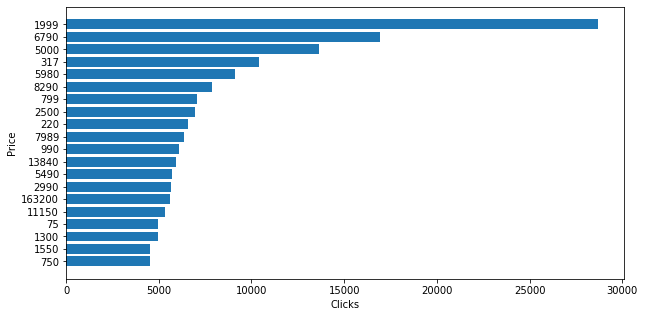

In [0]:
# plot the view
q1_plot = q1_pd[1:21][::-1]
plt.figure(figsize = (10, 5))
plt.barh(q1_plot['Price'], q1_plot['TotalClick'])
plt.xlabel('Clicks')
plt.ylabel('Price');

According to the bar chart, the clicks on ads is highest for the ad of price 1,999 with 28,661, and the following 3 are ads of price 6790, 5000, and 317. Most of the top 20 clicks on ads are for ads with relatively low prices. Therefore, we can say that the relationship between the ads price and clicks is not a positive correlation.

In [0]:
# change the Price column type into float
q1_plot2 = q1_pd[(q1_pd['Price'] != '') & (q1_pd['Price'].notnull())]
q1_plot2['Price'] = q1_plot2['Price'].astype('float')
q1_plot2

<command-2411578679744340>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 q1_plot2['Price'] = q1_plot2['Price'].astype('float')
Out[18]:

,Price,TotalClick
1,1999.0,28661
2,6790.0,16949
3,5000.0,13652
4,317.0,10422
5,5980.0,9129
...,...,...
4731,14388.0,0
4732,1816.5,0
4733,5828.0,0
4734,33652.0,0


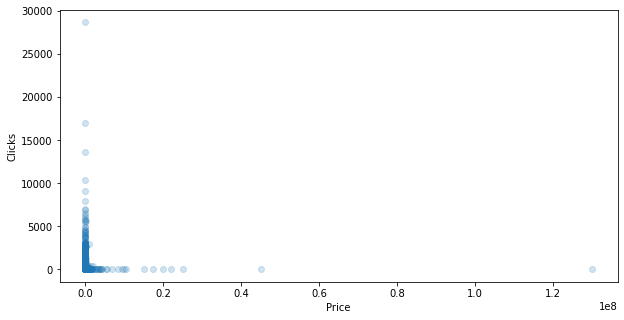

In [0]:
# plot the view
plt.figure(figsize = (10, 5))
plt.scatter(q1_plot2['Price'], q1_plot2['TotalClick'], alpha = 0.2)
plt.xlabel('Price')
plt.ylabel('Clicks');

According to the scatter plot, we can see a clear negative correlation relationship between the ads price and clicks. Most clicks are distributed on the left of the chart, which are ads with low price, while ads with high price rarely have clicks.

### Q2: What is the relationship between the ads type and search location?

In [0]:
type_location = spark.sql('''
                         SELECT ObjectType, Level, SUM(IsClick) as TotalClick
                         FROM search_click_view, category_view
                         GROUP BY ObjectType, Level
                         ORDER BY TotalClick DESC
                         ''')

type_location.show()

+----------+-----+----------+
ObjectType|Level|TotalClick|
+----------+-----+----------+
 3| 3| 64192184|
 3| 2| 12609179|
 3| 1| 1146289|
 1| 1| null|
 2| 3| null|
 2| 2| null|
 1| 3| null|
 1| 2| null|
 2| 1| null|
+----------+-----+----------+

In [0]:
# change Spark dataframe into Pandas dataframe
type_location_df = type_location.toPandas()

# change the null value into 0
type_location_df = type_location_df.fillna(0)
type_location_df

Out[14]:

,ObjectType,Level,TotalClick
0,3,3,64192184.0
1,3,2,12609179.0
2,3,1,1146289.0
3,1,1,0.0
4,2,3,0.0
5,2,2,0.0
6,1,2,0.0
7,1,3,0.0
8,2,1,0.0


The output shows that users prefer to click contextual ads.

Out[26]:

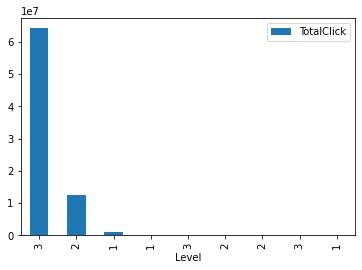

<AxesSubplot:xlabel='Level'>

In [0]:
# plot the view
type_location_df.plot.bar(x = 'Level', y = 'TotalClick')
plot.show()

The output shows that the number of click on the ad is highest for contextual ads in the city level with 64,192,184. The second one is the region level with total click of 12,609,179, and the third highest ads click number is 1,146,289 in coutry level. The instresting point is that only contextual ads has vailad vaules of total click. Regular free ads and highligted regular type of ads have null value concerning the total number of click. It seems that user prefer to click the ads which are relevant with the web page content.

### Q3: What is the relationship between ads click number and device type?

In [0]:
ads_device = spark.sql('''
                       SELECT UserDeviceID, SUM(IsClick) as TotalClick
                       FROM user_info_view, search_click_view           
                       GROUP BY UserDeviceID
                       ORDER BY TotalClick DESC LIMIT 10
                       ''')
ads_device.show()

+------------+-------------+
UserDeviceID| TotalClick|
+------------+-------------+
 25|1970029469735|
 64| 794876912715|
 62| 614038360075|
 85| 590699916035|
 15| 364859203544|
 9| 225767349995|
 7| 97590460304|
 63| 81663920938|
 72| 36882994864|
 43| 36872678263|
+------------+-------------+

In [0]:
# change Spark dataframe into Pandas dataframe
ads_device_df = ads_device.toPandas()
ads_device_df

Out[58]:

,UserDeviceID,TotalClick
0,25,1970029469735
1,64,794876912715
2,62,614038360075
3,85,590699916035
4,15,364859203544
5,9,225767349995
6,7,97590460304
7,63,81663920938
8,72,36882994864
9,43,36872678263


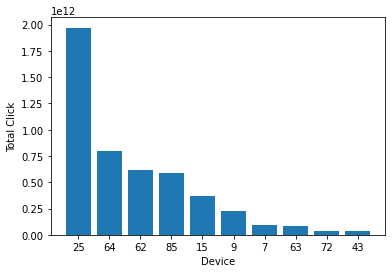

In [0]:
# plot the view
plt.bar(ads_device_df['UserDeviceID'], ads_device_df['TotalClick'])
plt.xlabel('Device')
plt.ylabel('Total Click')
plt.show()

The above bar plot displays the top 10 total number of clicks for ads for each type of device. Device 25 has 1970,029,469,735 ads clicks as the top 1 device type, which is two times more than the second device 64 with 794,876,912,715 clicks. Based on the result, this online advertising company could do more research for device 25 and upgrade the ads quality to attract more users.

### Q4: What is the relationship between categories and ads click?

In [0]:
category_isClick = spark.sql('''SELECT CategoryID, SUM(IsClick) as TotalClick
                                FROM ad_info_view, search_click_view           
                                GROUP BY CategoryID
                                ORDER BY TotalClick DESC LIMIT 10
                                ''')
category_isClick.show()

+----------+-------------+
CategoryID| TotalClick|
+----------+-------------+
 34|6382689608437|
 22|4489023619304|
 54|3264070536679|
 60|2827969471785|
 43|2242026655100|
 250005|1807733287959|
 38|1749600387613|
 50|1601267152146|
 47|1561739668559|
 42|1541772460468|
+----------+-------------+

In [0]:
# change Spark dataframe into Pandas dataframe
category_isClick_df = category_isClick.toPandas()
category_isClick_df

Out[24]:

,CategoryID,TotalClick
0,34,6382689608437
1,22,4489023619304
2,54,3264070536679
3,60,2827969471785
4,43,2242026655100
5,250005,1807733287959
6,38,1749600387613
7,50,1601267152146
8,47,1561739668559
9,42,1541772460468


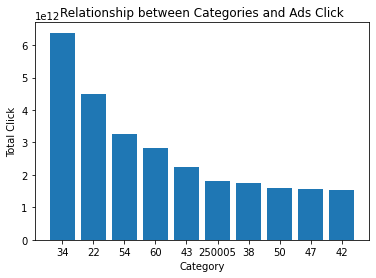

In [0]:
# plot the view
p = plt.bar(category_isClick_df['CategoryID'], category_isClick_df['TotalClick'])
plt.xlabel('Category')
plt.ylabel('Total Click')
plt.title("Relationship between Categories and Ads Click")
plt.show()

The above bar plot shows the top 10 categories as well as their total clicks of each category. The category 34 has 6,382,689,608,437 total clicks, which is the highest one among all the categories. Obviously, the second rank is category 22 with 4,489,023,619,304 clicks. However, the last five categories (250005, 38, 50, 47, 42) among the top 10 categories possess very  similar clicks, which are all under 200 trillion and above 150 trillion clicks. Furthermore, we can notice it based on their height of the plot. Therefore, this online advertising company should focus more on category 34 and advertise it actively.

d
## Executive Summary

According to this online advertising company system, we defined several questions to analyze 7 large datasets with PySpark and SparkSQL. Firstly, we imported 7 large datasets from Prof. Vaisman’s Azure Blob Location. Then, we split a cluster of columns of each file into seperate columns and included the index to get the order of the dataset. Afterthat, we explored multiple datasets to analyze and visualize the defined questions. In terms of the results, we listed some suggestions to improve the service of the online advertising company.

## Methods

- Source, ingeste, cleanse, prepare the dataset: PySpark 

  Firstly, we used `monotonically_increasing_id()` to get the the index of each file. And then we used `split()`, `withColumn()`, `filter()`, and `select()` to split a cluster of columns of each file into seperate columns.

- Analytical tools: SparkSQL, Matplotlib

  We used `createOrReplaceTempView()` to create SparkSQL views. Then wrote SQL codes to query data, and visualized them with Matplotlib. 

- Analytical questions:
    - What is the relationship between the ads price and clicks?
    - What is the relationship between the ads type and search location?
    - What is the relationship between ads click number and device type?
    - What is the relationship between categories and ads click?

## Challenges

- Technical: 

  There will be a large table if we combine two or more tables into one table, which may cause a longer running time and less code efficiency. In this case, we decided to use combining queries to aviod it.
  
- Non-technical:
  
  In the beginning, we are confused about the questions we were going to explore since we wanted to come up with some significant relationships between any two elements among these 7 large datasets. Finally, by looking through and analyze the Entity Relation diagram, we have found the four meaningful and interesting relationships to explore them by PySpark and Spark SQL Engine.

## Conclusion

Based on this online advertising company's system dataset, we found some relations between features. There is an negative relationship between ads price and ads click number. Users prefer to click contextual ads in the city search level than that in region and country level. Thus, advertising company could develop the design of contextual ads to attract more users. Afterthat, the bar plot between total click number and device type shows that users of device 25 have the highest number of ads click. Therefore, advertising company could update the ads setting and design to satisfies differnet device user. Last but not least, we analyzed the relationship between ads category and total numer of ads click. Based on the reault, we would suggest advertising company add more ads relevant to the category 34, 22 and 54. Lastly, we used the plots to validate the result of all the dataframes that we disposed.

## Future work

In terms of the future work, we could visualize the results with Tableau, which provides a more interpretable plot. Additionally,  we could find the original source of the data and monitor the data by setting a timer to automatically web scrape online ads data. Afterthat, we could refactor our program and create a UI page to customize providing more flexibility to users.

## Takeaways from the course
Based on the course, we have learned how to use PySpark and Spark SQL Engine. Then, we have utilized Spark SQL to run sql queries, which implemented select, order, and sum function and so on in order to acquire targeted information. After that, we used scatter plot, and histograms based on the gained information to show the solutions of the problems.

In the theoretical part, we learned how to use parallelization to accelerate the process of large datasets with MapReduce, the structure of Hadoop and other tools, the set up of AWS and MicroSoft Azure. The throretical and pratical part of this course brings us the structure and instruction to work with large datasets, dramatically helps us to prepare for the future jobs.